# Model Selection

This notebook shows how one can use the `comparison` submodule of `kosmatau3d` to compare the models with observations. A more convenient script is located in `tests/terminal scripts/run_comparison.py`.

***Note:*** *For now the observations must have the same gridding in longitude as the simulated models in order to calculate $\chi^2$.*

### open model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.io import fits
from copy import deepcopy
from kosmatau3d import models

#### test

This is an initial test of an object implemented in kosmatau3d.

In [52]:
files = {'intensity': 'synthetic_intensity', 
          'optical_depth': 'synthetic_optical_depth', 
          'dust_absorption': 'dust_absorption', 
          'dust_emissivity': 'dust_emissivity', 
          'species_absorption': 'species_absorption', 
          'species_emissivity': 'species_emissivity', 
          'density': 'voxel_density', 
          'ensemble_dispersion': 'voxel_ensemble_dispersion', 
          'ensemble_mass': 'voxel_ensemble_mass', 
          'fuv_absorption': 'voxel_fuv_absorption', 
          'fuv': 'voxel_fuv', 
          'position': 'voxel_position', 
          'velocity': 'voxel_velocity', }

class SyntheticModel():
    
    def __init__(self, base_dir=''):
        
        self.base_dir = base_dir
        self.files = {'intensity': 'synthetic_intensity', 
                      'optical_depth': 'synthetic_optical_depth', 
                      'dust_absorption': 'dust_absorption', 
                      'dust_emissivity': 'dust_emissivity', 
                      'species_absorption': 'species_absorption', 
                      'species_emissivity': 'species_emissivity', 
                      'density': 'voxel_density', 
                      'ensemble_dispersion': 'voxel_ensemble_dispersion', 
                      'ensemble_mass': 'voxel_ensemble_mass', 
                      'fuv_absorption': 'voxel_fuv_absorption', 
                      'fuv': 'voxel_fuv', 
                      'position': 'voxel_position', 
                      'velocity': 'voxel_velocity', }
        
        return
        
    def load_model(self, directory=None, intensity='synthetic_intensity', optical_depth='synthetic_optical_depth', 
                   dust_absorption='dust_absorption', dust_emissivity='dust_emissivity', 
                   species_absorption='species_absorption', species_emissivity='species_emissivity', 
                   density='voxel_density', ensemble_dispersion='voxel_ensemble_dispersion', ensemble_mass='voxel_ensemble_mass', 
                   fuv_absorption='voxel_FUVabsorption', fuv='voxel_fuv', position='voxel_position', velocity='voxel_velocity'):
        
        # Ensure model path exists
        if os.path.exists(self.base_dir + directory):
            pass
        else:
            print(f'Directory {self.base_dir + directory} is not valid!! Check to see if `base_dir` was set '
                  + 'when initialising or if the specified directory was correct.')
            return
        
        # Load all model data (can be expensive for memory)
        self.intensity_file = fits.open(self.base_dir + directory + intensity + '.fits')
        self.map_positions = self.intensity_file[0].data
        self.intensity_species = self.intensity_file[1].data
        self.intensity_dust = self.intensity_file[2].data
        self.optical_depth_file = fits.open(self.base_dir + directory + optical_depth + '.fits')
        self.optical_depth_species = self.optical_depth_file[1].data
        self.optical_depth_dust = self.optical_depth_file[2].data
        self.dust_absorption_file = fits.open(self.base_dir + directory + dust_absorption + '.fits')
        self.dust_absorption = self.dust_absorption_file[0].data
        self.dust_emissivity_file = fits.open(self.base_dir + directory + dust_emissivity + '.fits')
        self.dust_emissivity = self.dust_emissivity_file[0].data
        self.species_absorption_file = fits.open(self.base_dir + directory + species_absorption + '.fits')
        self.species_absorption = self.species_absorption_file[0].data
        self.species_emissivity_file = fits.open(self.base_dir + directory + species_emissivity + '.fits')
        self.species_emissivity = self.species_emissivity_file[0].data
        self.density_file = fits.open(self.base_dir + directory + density + '.fits')
        self.density = self.density_file[0].data
        self.ensemble_dispersion_file = fits.open(self.base_dir + directory + ensemble_dispersion + '.fits')
        self.ensemble_dispersion = self.ensemble_dispersion_file[0].data
        self.ensemble_mass_file = fits.open(self.base_dir + directory + ensemble_mass + '.fits')
        self.ensemble_mass = self.ensemble_mass_file[0].data
        self.fuv_absorption_file = fits.open(self.base_dir + directory + fuv_absorption + '.fits')
        self.fuv_absorption = self.fuv_absorption_file[0].data
        self.fuv_file = fits.open(self.base_dir + directory + fuv + '.fits')
        self.fuv = self.fuv_file[0].data
        self.position_file = fits.open(self.base_dir + directory + position + '.fits')
        self.position = self.position_file[0].data
        self.velocity_file = fits.open(self.base_dir + directory + velocity + '.fits')
        self.velocity = self.velocity_file[0].data
        
        # Extract and create additional axes
        self.species_header = self.intensity_file[1].header
        self.species_header['BUNIT'] = self.intensity_file[1].header['BUNIT']+'/'+self.optical_depth_file[1].header['BUNIT']
        self.dust_header = self.intensity_file[2].header
        self.species = self.species_header['SPECIES'].split(', ')
        self.dust = self.dust_header['DUST'].split(', ')
        self.dust_header['BUNIT'] = self.intensity_file[2].header['BUNIT']+'/'+self.optical_depth_file[2].header['BUNIT']
        self.map_lon = np.linspace(self.species_header['CRVAL2'] - self.species_header['CDELT2']*(self.species_header['CRPIX2']-0.5), 
                                   self.species_header['CRVAL2'] + self.species_header['CDELT2']*(self.species_header['NAXIS2']-self.species_header['CRPIX2']-0.5), 
                                   num=self.species_header['NAXIS2'])
        self.map_lat = np.linspace(self.species_header['CRVAL3'] - self.species_header['CDELT3']*(self.species_header['CRPIX3']-0.5), 
                                   self.species_header['CRVAL3'] + self.species_header['CDELT3']*(self.species_header['NAXIS3']-self.species_header['CRPIX3']-0.5), 
                                   num=self.species_header['NAXIS3'])
        self.map_vel = np.linspace(self.species_header['CRVAL4'] - self.species_header['CDELT4']*(self.species_header['CRPIX4']-0.5), 
                                   self.species_header['CRVAL4'] + self.species_header['CDELT4']*(self.species_header['NAXIS4']-self.species_header['CRPIX4']-0.5), 
                                   num=self.species_header['NAXIS4'])
        
        return

In [50]:
model = SyntheticModel()
model.load_model(base_dir.replace('observational_data', 'KT3_history') + 'r400_modtest/')

#### functionality

In [9]:
model = models.SyntheticModel(base_dir='/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/')

In [10]:
model.load_model(directory='r400_fhi0.7_fuv1.0/')

In [4]:
model.get_dust_wavelengths()

[Unit("0.00055 m"), Unit("0.00024 m")]

In [11]:
model.map_lat

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

In [124]:
model.info


voxel_size: 100.0 pc

--------------------------------------------------
                Model Information
--------------------------------------------------
It is necessary to have a record of the
relevant model information in each file,
so below we record the relevant information
defining the model parameters.

r100_convergence/


Grid files

clump_Tmb_LineCenter.dat
clump_tau_LineCenter.dat
RhoMassAFUV.dat

Input files

h2_mass_profile.dat
hi_mass_profile.dat
 same as h2: hi_mass_profile.dat
densities_clouds.dat
galactic_FUV_complete.dat
  average spectrum: False
  integration range: (912, 2066)
rot_milki2018_14.dat

improved calculation: True


                      Model

          Model shape: disk
               x (pc): 36000.0
               y (pc): 36000.0
               z (pc): 0.0
          radius (pc): 18000
       R_gal,Sun (pc): 8178


               Ensemble properties

   mass range (M_Sun): [[0, 2], [-2]]
             # clumps: [3, 1]
     log m_cl (M_Sun): [array([[0

In [5]:
model100.get_volume_filling_factor().mean(), model400.get_volume_filling_factor().mean()

(0.0011684827615148342, 0.00029224036265724373)

In [4]:
np.mean(model100.get_volume_filling_factor()) / np.mean(model400.get_volume_filling_factor())

3.9983620020527346

In [23]:
np.max(model100.ensemble_mass), np.max(model400.ensemble_mass)

(14211333.6, 14211333.6)

In [13]:
np.max(model400.ensemble_mass) / np.max(model100.ensemble_mass)

16.0

In [18]:
np.median(model100.get_species_intensity(transition='C+ 1', include_dust=True)) / np.median(model400.get_species_intensity(transition='C+ 1', include_dust=True))

1.0020046716043707

In [7]:
model.species

['C+ 1',
 'C 1',
 'C 2',
 'CO 1',
 'CO 2',
 'CO 3',
 'CO 4',
 'CO 5',
 'CO 6',
 'CO 7',
 'CO 8',
 '13C+ 1',
 '13C 1',
 '13C 2',
 '13CO 1',
 '13CO 2',
 '13CO 3',
 '13CO 4',
 '13CO 5',
 '13CO 6',
 '13CO 7',
 '13CO 8',
 'HCO+ 1',
 'HCO+ 2',
 'HCO+ 3',
 'HCO+ 4',
 'HCO+ 5']

In [8]:
model.dust

['550um', '240um']

/tmp/ipykernel_478782/610753459.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(model.get_species_intensity(transition='C+ 1', include_dust=False))[:, 4, 360]) ;


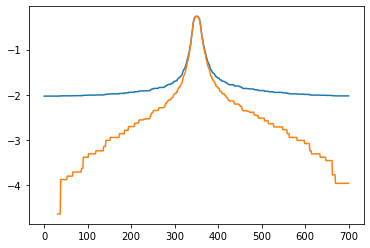

In [4]:
%matplotlib inline

plt.plot(np.log10(model.get_species_intensity(transition='C+ 1', include_dust=True))[:, 4, 360])
plt.plot(np.log10(model.get_species_intensity(transition='C+ 1', include_dust=False))[:, 4, 360]) ;

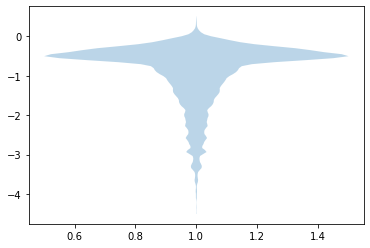

In [6]:
import matplotlib.pyplot as plt

idx = 4
integrate = False

data = model.get_species_intensity(idx=idx, integrated=integrate)
i_nan = data <= 0
plt.violinplot([np.log10(data[~i_nan]).flatten()], widths=1, showextrema=False) ;

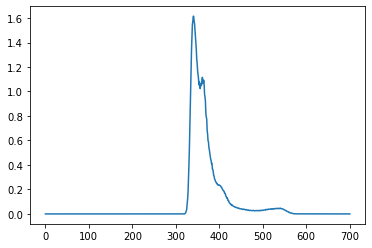

In [ ]:
intensity = model.get_species_intensity(transition='CO 1', include_dust=False)
plt.plot(intensity[:, 4, 375])

In [54]:
def hexbin_comp(model, transitions=('CO 1', '13CO 1'), 
                xlabel=r'$\varpi_\mathrm{^{12}CO \, 1 \to 0}$', ylabel=r'$\varpi_\mathrm{^{13}CO \, 1 \to 0}$', 
                xrange=(-3, 2), fontsize=24, ticksize=16, figsize=(10, 10), 
                tau=[0.1, 0.3, 0.5, 1, 5], i_text=[-1, -1, -1, -1, -3],
                filename='hist2d_r400_convergence.png', plot_dir = 'plots/'):
    
    xval = model.get_species_intensity(transition=transitions[0], include_dust=False)[:, :, :]
    yval = model.get_species_intensity(transition=transitions[1], include_dust=False)[:, :, :]
    i_nan = xval == 0

    xmin = ymin = xrange[0]
    xmax = ymax = xrange[1]
    R_13 = 60
    tau_13 = tau
    i_text = i_text

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    cm = ax.hexbin(xval[~i_nan], yval[~i_nan], 
                    bins='log', xscale='log', yscale='log', gridsize=25, cmap='Reds', extent=(xmin, xmax, ymin, ymax))
    # cb = fig.colorbar(cm, ax=ax) 
    # cb.set_label(r'$\mathrm{log_{10}}(N)$')
    for i, tau in enumerate(tau_13):
        x_fit = 10**np.linspace(xmin, xmax, num=100)
        y_fit = x_fit * (1-np.exp(-tau)) / (1-np.exp(-R_13*tau))
        rot = np.arctan((np.log10(y_fit[-1])-np.log10(y_fit[0]))/(np.log10(x_fit[-1])-np.log10(x_fit[0])))
        ax.plot(x_fit, y_fit, c='xkcd:black')
        plt.text(x_fit[i_text[i]], y_fit[i_text[i]], r'$\tau_{13}$' + f' = {tau}', 
                 ha='right', va='bottom', c='xkcd:black', rotation=45, rotation_mode='anchor', fontsize=ticksize)
    ax.set_xlim(10**xmin, 10**xmax) 
    ax.set_ylim(10**ymin, 10**ymax)
    ax.set_xlabel(xlabel + r' (K km s$^{-1}$)', fontsize=fontsize)
    ax.set_ylabel(ylabel + r' (K km s$^{-1}$)', fontsize=fontsize)
    fig.tight_layout();
    plt.savefig(plot_dir + filename)
    # plt.show()
    plt.close('all')
    return

In [36]:
np.linspace(1, 3, num=17)

array([1.   , 1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   ,
       2.125, 2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   ])

In [63]:
model = models.SyntheticModel(base_dir='/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/')
params = np.meshgrid([0.3, 0.4, 0.5, 0.6, 0.7], 10**np.linspace(0, 2, num=17))
for param in [400, 200, 100]:
    print(param)
    model_dir = f'r{param}_convergence/'
    print(model_dir)
    model.load_model(directory=model_dir)
    hexbin_comp(model, transitions=('C 1', '13C 1'), xrange=(-5, -1), 
                xlabel=r'$\varpi_\mathrm{[^{12}CI] \, 1 \to 0}$', ylabel=r'$\varpi_\mathrm{[^{13}CI] \, 1 \to 0}$', 
                filename='hist2d_C_' + model_dir.replace('/', '.png'), 
                ticksize=14, tau=(0.1, 1, 10), i_text=(-1, -1, -1))

400
r400_convergence/
200
r200_convergence/
100
r100_convergence/


In [64]:
model = models.SyntheticModel(base_dir='/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/')
params = np.meshgrid([0.3, 0.4, 0.5, 0.6, 0.7], 10**np.linspace(0, 2, num=17))
for param in zip(*(p.flatten() for p in params)):
    print(param)
    model_dir = f'r400_fhi{param[0]:.1f}_fuv{param[1]:.1f}/'
    print(model_dir)
    model.load_model(directory=model_dir)
    hexbin_comp(model, filename='hist2d_' + model_dir.replace('/', '.png'))

(0.3, 1.0)
r400_fhi0.3_fuv1.0/
(0.4, 1.0)
r400_fhi0.4_fuv1.0/
(0.5, 1.0)
r400_fhi0.5_fuv1.0/
(0.6, 1.0)
r400_fhi0.6_fuv1.0/
(0.7, 1.0)
r400_fhi0.7_fuv1.0/
(0.3, 1.333521432163324)
r400_fhi0.3_fuv1.3/
(0.4, 1.333521432163324)
r400_fhi0.4_fuv1.3/
(0.5, 1.333521432163324)
r400_fhi0.5_fuv1.3/
(0.6, 1.333521432163324)
r400_fhi0.6_fuv1.3/
(0.7, 1.333521432163324)
r400_fhi0.7_fuv1.3/
(0.3, 1.7782794100389228)
r400_fhi0.3_fuv1.8/
(0.4, 1.7782794100389228)
r400_fhi0.4_fuv1.8/
(0.5, 1.7782794100389228)
r400_fhi0.5_fuv1.8/
(0.6, 1.7782794100389228)
r400_fhi0.6_fuv1.8/
(0.7, 1.7782794100389228)
r400_fhi0.7_fuv1.8/
(0.3, 2.371373705661655)
r400_fhi0.3_fuv2.4/
(0.4, 2.371373705661655)
r400_fhi0.4_fuv2.4/
(0.5, 2.371373705661655)
r400_fhi0.5_fuv2.4/
(0.6, 2.371373705661655)
r400_fhi0.6_fuv2.4/
(0.7, 2.371373705661655)
r400_fhi0.7_fuv2.4/
(0.3, 3.1622776601683795)
r400_fhi0.3_fuv3.2/
(0.4, 3.1622776601683795)
r400_fhi0.4_fuv3.2/
(0.5, 3.1622776601683795)
r400_fhi0.5_fuv3.2/
(0.6, 3.1622776601683795)
r

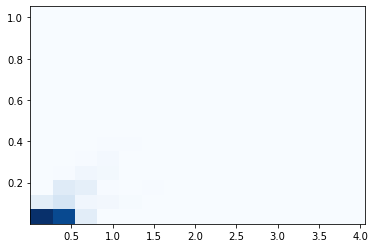

In [20]:
xval = model.get_species_intensity(transition='CO 1', include_dust=False)[:, 4, :]
yval = model.get_species_intensity(transition='13CO 1', include_dust=False)[:, 4, :]
i_nan = xval == 0
cm = plt.hist2d(xval[~i_nan], yval[~i_nan], 
                bins=15, cmap='Blues')
# plt.colorbar(cm) ;

### regrid surveys

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from kosmatau3d import comparison as comp

In [2]:
# Path to observational data survey folders
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/'

# target header and kernel for regridding
target_header = {
    'NAXIS': 3,
    'NAXIS1': 721,
    'NAXIS2': 361,
    'NAXIS3': 701,
    'CTYPE1': 'GLON-CAR',
    'CRVAL1': 0,
    'CDELT1': 0.5,
    'CRPIX1': 361,
    'CTYPE2': 'GLAT-CAR',
    'CRVAL2': 0,
    'CDELT2': 0.5,
    'CRPIX2': 181,
    'CTYPE3': 'VELO',
    'CRVAL3': 0,
    'CDELT3': 1,
    'CRPIX3': 351,
}
kernel_sigma = 0.25
target_kernel = (
    'gauss1d',
    (kernel_sigma,),
    kernel_sigma*3,
    kernel_sigma/2,
)

# List of survey missions to work on
mission = ['COBE-DIRBE']#['COGAL', 'SEDIGISM', 'Mopra', 'ThrUMMS']

In [3]:
comp.regrid_observations(
    path=base_dir,
    mission=['COBE-DIRBE'],
    target_header=target_header,
    target_kernel=target_kernel,
)

Regridding COBE-DIRBE survey
COBE-DIRBE
DIRBE_BAND10_ZSMA.FITS
Regrid successfully completed.


0

### surveys

#### open survey

In [32]:
fits.open('/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/SEDIGISM/regridded/temp/13co2_test_regridded_error.fits')[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  721                                                  
NAXIS2  =                  361                                                  
CTYPE1  = 'GLON-CAR'                                                            
CRVAL1  =                    0                                                  
CDELT1  =                  0.5                                                  
CRPIX1  =                  361                                                  
CTYPE2  = 'GLAT-CAR'                                                            
CRVAL2  =                    0                                                  
CDELT2  =                  0.5                                                  
CRPIX2  =                  1

In [33]:
from kosmatau3d.comparison.Observation import *

In [34]:
obs = Observation(base_dir='/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/', regridded_dir='/regridded/temp/')

In [35]:
obs.load_survey(survey='COGAL')

In [5]:
obs.obs_header

[SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -32 / array data type                                
 NAXIS   =                    3 / number of array dimensions                     
 NAXIS1  =                  721                                                  
 NAXIS2  =                  361                                                  
 NAXIS3  =                  701                                                  
 CTYPE1  = 'GLON-CAR'                                                            
 CRVAL1  =                    0                                                  
 CDELT1  =                  0.5                                                  
 CRPIX1  =                  361                                                  
 CTYPE2  = 'GLAT-CAR'                                                            
 CRVAL2  =                    0                                                  
 CDELT2  =      

In [9]:
obs.get_intensity(idx=0, trimmed=True).shape

craig.idl
craig.idl


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [36]:
xval = obs.get_intensity(idx=1)[:, 4, :]
yval = obs.get_intensity(idx=0)[:, 4, :]
i_nan = xval <= 0
cm = plt.hexbin(xval[~i_nan], yval[~i_nan], 
                bins='log', xscale='log', yscale='log', gridsize=15, cmap='Blues')
plt.colorbar(cm) ;

co1_test_regridded.fits
13co1_test_regridded.fits


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 432x288 with 2 Axes>

In [62]:
obs.files

['craig.idl',
 'FIRAS_LINE_EMISSION_MAP_HIGH_regridded.fits',
 'FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits',
 'FIRAS_LINE_EMISSION_MAP_LOWF_regridded.fits']

In [65]:
for err in obs.obs_error_data:
    print(err.shape)

(73, 19)
(10, 181, 361)
(8, 181, 361)
(8, 181, 361)


In [4]:
obs.obs_iid

[(array([b'CO 1-0', b'CO 2-1', b'CO 3-2', b'O_2', b'CO 4-3', b'C^0 (609)',
         b'Ortho H_2O', b'CO 5-4', b'CO 6-5', b'CO 7-6 +C^0 (370)',
         b'Para H_2O', b'N^+ (205)', b'Para H_2O', b'C^+', b'O_0', b'Si_0',
         b'N^+', b'CH', b'CO 8-7'], dtype=object),
  array(['CO 1', 'CO 2', 'CO 3', 'CO 4', 'C 3', 'CO 5', 'CO 6',
         'CO 7 + C 1', 'C+ 1', 'O 1', 'CO 8'], dtype='<U10')),
 ['CO 6',
  'C 2',
  'H2O f1113',
  'N+ 1',
  'H2O 2',
  'C+ 1',
  'O 1',
  'Si',
  'N+ 2',
  'CH 2'],
 ['CO 1', 'CO 2', 'CO 3', 'O2 13', 'CO 4', 'C 1', 'H2O f557', 'CO 5'],
 ['CO 1', 'CO 2', 'CO 3', 'CO 4', 'C 1', 'CO 5']]

In [5]:
obs.get_obs_extent(idx=0)

craig.idl


(array([-180., -175., -170., -165., -160., -155., -150., -145., -140.,
        -135., -130., -125., -120., -115., -110., -105., -100.,  -95.,
         -90.,  -85.,  -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,
         -45.,  -40.,  -35.,  -30.,  -25.,  -20.,  -15.,  -10.,   -5.,
           0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,
         135.,  140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.,
         180.], dtype=float32),
 array([0]),
 None)

In [14]:
obs.get_intensity(idx=0, trimmed=False, integrated=True).shape

13co1_test_regridded.fits


(181, 361)

In [19]:
obs.obs_header

[SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -32 / array data type                                
 NAXIS   =                    3 / number of array dimensions                     
 NAXIS1  =                  721                                                  
 NAXIS2  =                  361                                                  
 NAXIS3  =                    1                                                  
 CTYPE1  = 'GLON-CAR'                                                            
 CRVAL1  =                    0                                                  
 CDELT1  =                  0.5                                                  
 CRPIX1  =                  361                                                  
 CTYPE2  = 'GLAT-CAR'                                                            
 CRVAL2  =                    0                                                  
 CDELT2  =      

#### view survey

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  361                                                  
NAXIS2  =                  181                                                  
NAXIS3  =                    8                                                  
CTYPE1  = 'GLON-CAR'                                                            
CRVAL1  =                    0                                                  
CDELT1  =                    1                                                  
CRPIX1  =                  181                                                  
CTYPE2  = 'GLAT-CAR'                                                            
CRVAL2  =                    0                                                  
CDELT2  =                   

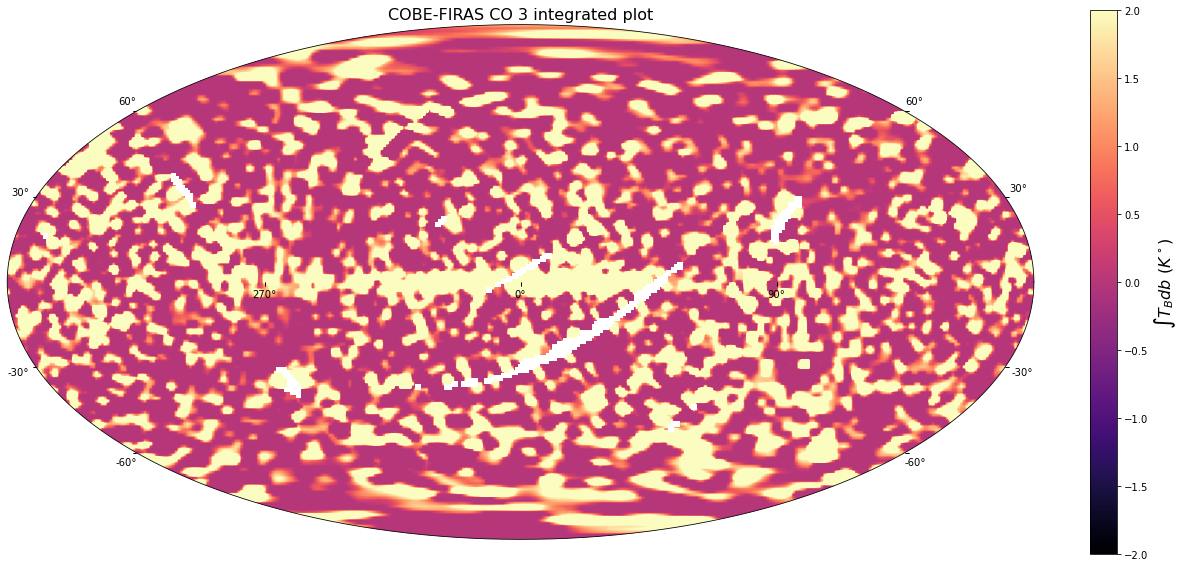

In [5]:
%matplotlib inline
comp.view_observation(
    path='/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/',
    mission='COGAL',
    regridded_path='/regridded/temp/',
    # regridded_path='/regridded/',
    list_observations=False,
    # regridded_path='',
    # filename='G300.5-12CO_Vfull_regridded.fits',
    #FIRAS HIGH: CO 6, C 2, C+ 1, O 1
    #FIRAS HRES:
    # filename='FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits',
    # filename='dust_COM_CompMap_dust-commander_0256_R2.00.fits',
    # filename='co1_test_regridded_error.fits',
    filename='co1_test_regridded.fits',
    # filename='planck_dust_regridded.fits',
    # filename='13co2_test_regridded_error.fits',
    # filename='13co2_test_regridded.fits',

    # filename='G001_13CO21_Tmb_DR1.fits',
    transition='CO 3',
    plot='integrated',
    integrate_b=None,
    # i_lat=91,
    # ylabel=r'$I_{CII}$ $(nW \ m^{-2} \ sr^{-1})$',
    clabel=r'$\int T_{B}db$ $(K^\circ)$',
    # title=r'COGAL CO $1 \rightarrow 0$',
    scale=0.5,
    logval=False,
    vmin=-2,
    vmax=2,
    # xlim=[60, 180],
    # ylim=[-200, 200],
    # cmap='gist_ncar',
    cmap='magma',
    save=False,
)

### compare to models

In [ ]:
# Available directories:
# - '/r400_cm{}-{}_d{}_uv{:.0f}/'
#   [[0.25, 0.5, 1.0, 2.0, 4.0], [1.0, 2.0], [0.25, 0.5, 1.0, 2.0, 4.0], [10, 100]]
# - '/r400_fcm{}_ficm{}/'
#   [[0.25, 0.5, 1.0, 2.0, 4.0], [0.25, 0.5, 1.0, 2.0, 4.0]]
# - '/r400_fcm{}_cm{}/'
#   [[0.25, 0.5, 1.0, 2.0, 4.0], ['0_2', '0_3', '-1_2', '-1_3']]
# - '/r400_ficm{}_icm{}/'
#   [[0.25, 0.5, 1.0, 2.0, 4.0], ['-2', '-2_-1', '-3_-1', '-3_-2']]
# - '/r400_rcmz{:.0f}_uv{}/'
#   [np.arange(0, 3001, 200), [10, 50, 100]]
comp.model_selection(
    mission=['COBE-FIRAS'],
    lat=None,
    PLOT=False,
    debug=False,
    cmap='viridis',
    model_dir='/r400_rcmz{:.0f}_uv{}/',
    model_param=[np.arange(0, 3001, 200), [10, 50, 100]],
    PRINT=True,
    )

### plot comparison results

In [37]:
%matplotlib inline
# This should be set to used to create plots of the model comparison for
#  various 2-dimensional grids. For grids with more parameters, the other
#  parameters will be identified via subplots.
comp.plot_comparison(
    missions=['COGAL'],
    file_format='r400_fcm{}_ficm{}',
    model_param=[[0.25, 0.5, 1.0, 2.0, 4.0], [0.25, 0.5, 1.0, 2.0, 4.0]],
    normalise=True,
    log=False,
    contour=True,
    levels=100,
    xlabel=r'$f_{clump}$',
    ylabel=r'$f_{interclump}$',
    clabel=r'$log_{10}(\mathcal{L})$',
#     supxlabel=r'$f_{FUV}$',
#     supylabel=r'$f_{\rho}$',
    fraction=0.045,
    clabel_xa=0.95,
    aspect=20,
    figsize=(10, 10),
    pad=1,
    pad_left=0.1,
    pad_right=0.1,
    pad_bottom=0.05,
    pad_top=0.05,
#     wspace=0.3,
    fontsize=24,
    save_plot=False,
    verbose=False,
    output_format='eps',
)

['COGAL']


In [22]:
list((0, 5))

[0, 5]

In [30]:
arr = np.zeros(3, dtype=object)
arr[[True, False, True]] = (2, 5)
arr

array([2, 0, 5], dtype=object)

['COBE-FIRAS', 'COGAL', 'Mopra', 'Planck', 'SEDIGISM', 'ThrUMMS']

COBE-FIRAS

FIRAS_LINE_EMISSION_MAP_HIGH2_regridded
  transitions CH 2, CO 6, H2O 2, H2O f1113, N+ 1, N+ 2, O 1, Si not available.
FIRAS_LINE_EMISSION_MAP_HIGH_regridded
  transitions CH 2, CO 6, H2O 2, H2O f1113, N+ 1, N+ 2, O 1, Si not available.
FIRAS_LINE_EMISSION_MAP_HRES_regridded
  transitions H2O f557, O2 13 not available.
FIRAS_LINE_EMISSION_MAP_LOWF_regridded


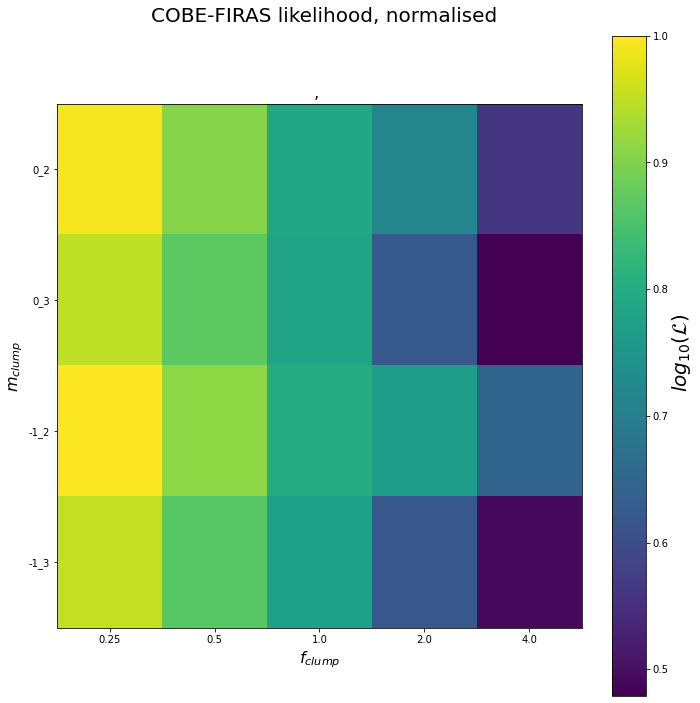


COGAL

co1_test_regridded


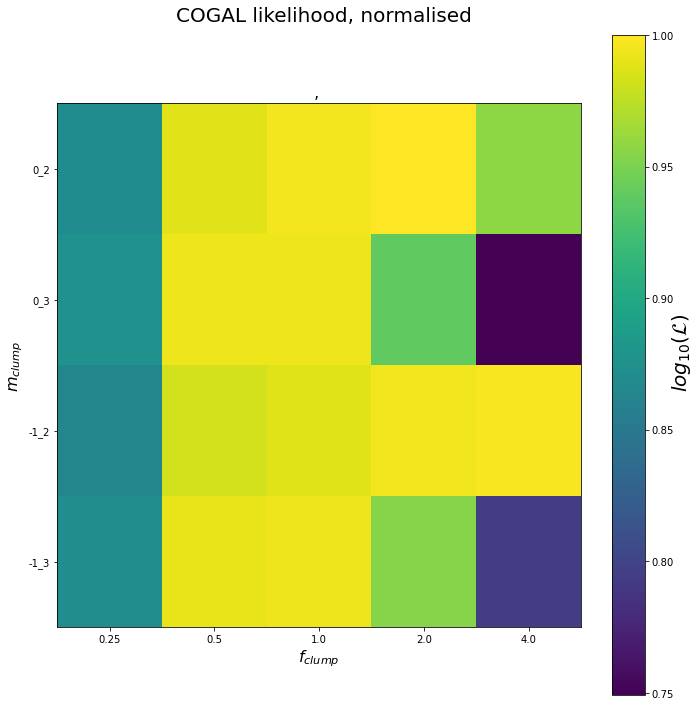


Mopra

13co1_test_regridded
co1_test_regridded


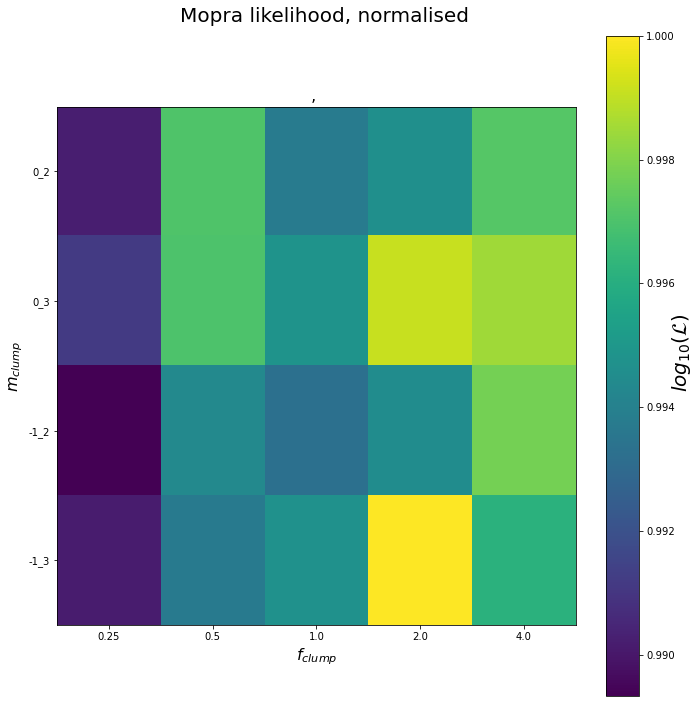


Planck

planck_dust_regridded


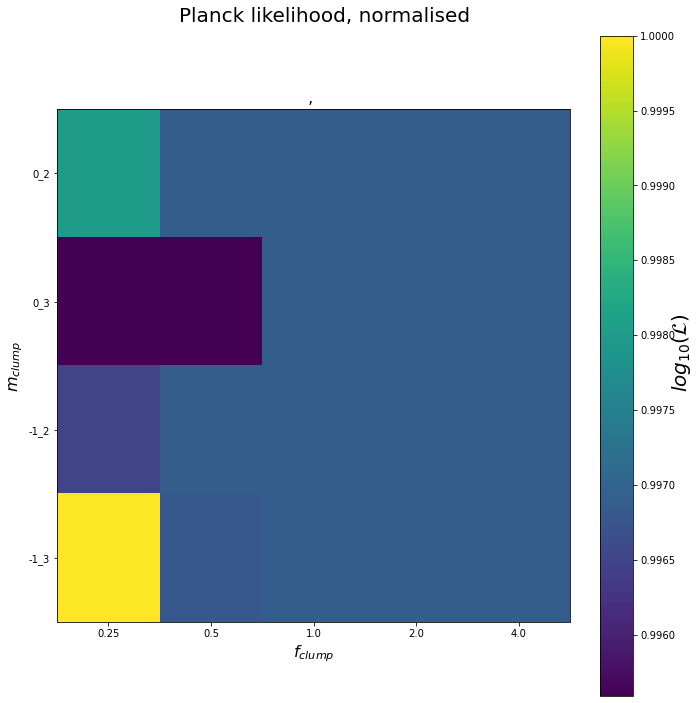


SEDIGISM

13co2_test_regridded


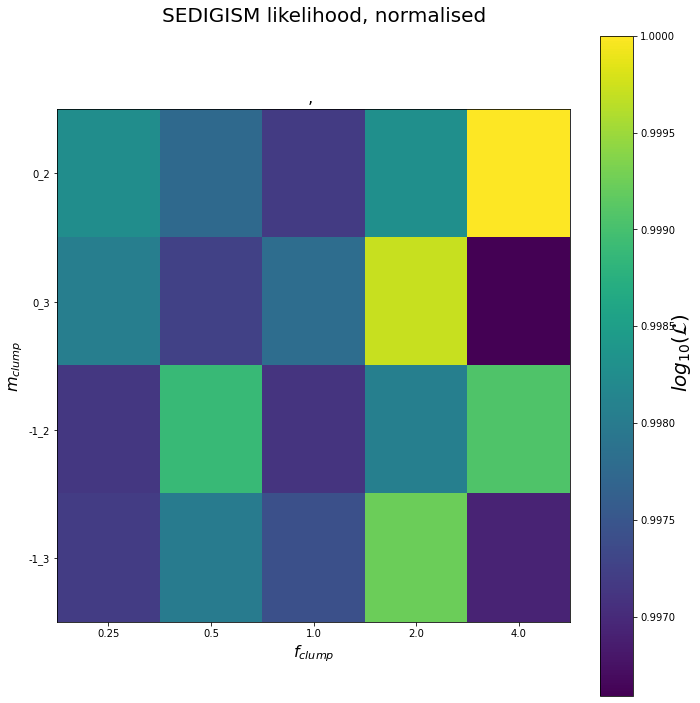


ThrUMMS

13co1_test_regridded
co1_test_regridded


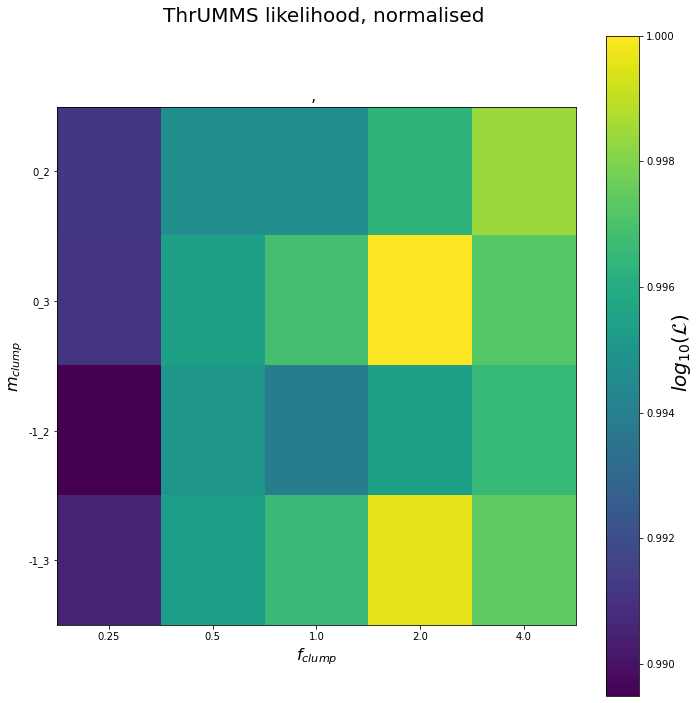

In [3]:
%matplotlib inline
# This should be set to used to create plots of the model comparison for
#  various 2-dimensional grids. For grids with more parameters, the other
#  parameters will be identified via subplots.
comp.plot_comparison(
    missions=None,
    file_format='r400_fcm{}_cm{}',
    model_param=[['0.25', '0.5', '1.0', '2.0', '4.0'], ['0_2', '0_3', '-1_2', '-1_3']],
    normalise=True,
    log=False,
    contour=False,
    levels=25,
    xlabel=r'$f_{clump}$',
    ylabel=r'$m_{clump}$',
    clabel=r'$log_{10}(\mathcal{L})$',
    verbose=True,
)

### violin plots

In [1]:
import ipywidgets as widgets
import numpy as np
import os

from IPython.display import clear_output
from kosmatau3d import comparison as comp

/home/yanitski/kosmatau3d/kosmatau3d/comparison/model_selection.py:2301: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if title is '':


In [4]:
%matplotlib inline

violin_kwargs = {'path' : '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/',
                 'survey' : 'COGAL',
                 'obs_file' : 'co1_test_regridded',
                 'file_format' : 'r{}_convergence/',
                 'model_param' : [[400, 200, 100]],
                 'log_comp' : True,
                 'lat' : 0,
                 'comp_type' : 'pv'}
violin_plot_kwargs = {'ylim' : [-1, 3],
                      'ylabel' : '',
                      'title' : None,
                      'violin_width' : 1,
                      'violin_spacing': 2,
                      'label_rotation' : -90,
                      'label_fontsize' : 12,
                      'fontsize' : 40,
                      'figsize' : (10, 10),
                      'save_plot' : False,
                      'output_file' : '',
                      'output_format' : 'png'}

In [5]:
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/'
surveys = os.listdir(base_dir)
surveys.remove('GRS')
surveys.remove('HiGAL')
surveys.sort()
survey_files = ['co1_test_regridded.fits', 'co2_test_regridded.fits', 'co3_test_regridded.fits',
                '13co1_test_regridded.fits', '13co2_test_regridded.fits', '13co3_test_regridded.fits',
                'GOTC+_regridded.fits', 'planck_dust-commander_regridded.fits', 
                'planck_Dust-GNILC-F353_regridded.fits', 'planck_Dust-GNILC-F545_regridded.fits', 'planck_Dust-GNILC-F857_regridded.fits',
                'FIRAS_LINE_EMISSION_MAP_HIGH_regridded.fits', 'FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits', 'FIRAS_LINE_EMISSION_MAP_LOWF_regridded.fits', 
                'DIRBE_BAND10_ZSMA_regridded.fits']

violin_survey = widgets.Dropdown(options=surveys,
                                 value='COGAL',
                                 description='Survey:')
violin_survey_file = widgets.Dropdown(options=survey_files,
                                      value='co1_test_regridded.fits',
                                      description='Survey file:')

violin_integrated = widgets.Checkbox(description='Integrated', value=True)
violin_log_comp = widgets.Checkbox(description='Log', value=True)

violin_plot_violin_width_slider = widgets.FloatSlider(min=0.1, max=10, value=1, step=0.1, description='width', orientation='vertical')
violin_plot_violin_spacing_slider = widgets.FloatSlider(min=0.1, max=10, value=2, step=0.1, description='spacing', orientation='vertical')
violin_plot_ylim_slider = widgets.FloatRangeSlider(min=-10, max=10, value=(-10, 10), step=0.5, description='ylim', orientation='vertical')
violin_plot_fontsize_slider = widgets.IntSlider(min=10, max=60, value=40, step=1, description='fontsize', orientation='vertical')
violin_plot_label_fontsize_slider = widgets.IntSlider(min=10, max=60, value=12, step=1, description='label size', orientation='vertical')
violin_plot_label_rotation_slider = widgets.IntSlider(min=-180, max=180, value=-45, step=1, description='label rotation', orientation='vertical')
violin_plot_save_file = widgets.Text(description='Output file')
violin_plot_save = widgets.Checkbox(description='Save')
violin_plot_button = widgets.Button(description='Plot')

violin_output = widgets.Output()

def set_violin_plot_params():
    
    violin_kwargs['surveys'] = violin_survey.value
    violin_kwargs[violin_survey.value+'_files'] = violin_survey_file.value
    if violin_integrated.value:
        violin_kwargs['comp_type'] = 'integrated'
    else:
        violin_kwargs['comp_type'] = 'pv'
    if violin_log_comp.value:
        violin_kwargs['log_comp'] = True
    else:
        violin_kwargs['log_comp'] = False
        
    violin_plot_kwargs['violin_width'] = violin_plot_violin_width_slider.value
    violin_plot_kwargs['violin_spacing'] = violin_plot_violin_spacing_slider.value
    violin_plot_kwargs['ylim'] = violin_plot_ylim_slider.value
    violin_plot_kwargs['fontsize'] = violin_plot_fontsize_slider.value
    violin_plot_kwargs['label_fontsize'] = violin_plot_label_fontsize_slider.value
    violin_plot_kwargs['label_rotation'] = violin_plot_label_rotation_slider.value
    violin_plot_kwargs['output_file'] = violin_plot_save_file.value
    violin_plot_kwargs['save_plot'] = violin_plot_save.value
    
    return

def violin_plot(b):
    with violin_output:
        clear_output()
        set_violin_plot_params()
        # kwargs['surveys'] = violin_survey.value
        # kwargs[violin_survey.value+'_files'] = violin_survey_file.value
        # if violin_integrated.value:
        #     kwargs['comp_type'] = 'integrated'
        # else:
        #     kwargs['comp_type'] = 'pv'
        # if violin_log_comp.value:
        #     kwargs['log_comp'] = True
        # else:
        #     kwargs['log_comp'] = False
        comp.violin_comparison(**violin_kwargs, **violin_plot_kwargs)

violin_plot_button.on_click(violin_plot)

violin_selector = widgets.HBox((widgets.VBox((violin_survey, violin_survey_file, )), widgets.VBox((violin_integrated, violin_log_comp, )), ))
violin_plot_params = widgets.HBox((violin_plot_violin_width_slider, 
                                  violin_plot_violin_spacing_slider,
                                  violin_plot_ylim_slider,
                                  violin_plot_fontsize_slider,
                                  violin_plot_label_fontsize_slider,
                                  violin_plot_label_rotation_slider,))
widgets.VBox((violin_selector, violin_plot_params, violin_plot_save_file, violin_plot_save, violin_plot_button, violin_output, ))

### ratio boxplots

In [1]:
import ipywidgets as widgets
import numpy as np
import os

from IPython.display import clear_output
from kosmatau3d import comparison as comp

In [2]:
ratio_kwargs = {'obs_path' : '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/',
                'model_path' : '/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/',
                'missions' : ['COBE-FIRAS', 'Planck'],
                'transitions' : ['CO 1', 'Dust'],
                'survey_files' : ['FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits', 'planck_dust-commander_regridded.fits'],
                # 'file_format' : 'r400_fhi{}_fuv{}/',
                # 'model_param' : [[1.0, 0.8, 0.6, 0.4], [10, 31, 100, 316, 1000]],
                'file_format' : 'r{}_convergence/',
                'model_param' : [[400, 200, 100]],
                'log_comp' : True,
                'lat' : None,
                'comp_type' : 'integrated'}
ratio_plot_kwargs = {'ylim' : (2, 6),
                     'ylabel' : '',
                     'title' : '',
                     'violin_width' : 1,
                     'violin_spacing' : 2,
                     'label_rotation' : -45,
                     'label_fontsize' : 12,
                     'fontsize' : 40,
                     'figsize' : (),
                     'save_plot' : False,
                     'output_file' : 'COBE-FIRAS-Planck_co1_boxplot',
                     'output_format' : 'png'}

In [3]:
%matplotlib inline
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/'
surveys = os.listdir(base_dir)
surveys.remove('GRS')
surveys.remove('HiGAL')
surveys.sort()
survey_files = ['co1_test_regridded.fits', 'co2_test_regridded.fits', 'co3_test_regridded.fits',
                '13co1_test_regridded.fits', '13co2_test_regridded.fits', '13co3_test_regridded.fits',
                'GOTC+_regridded.fits', 'planck_dust-commander_regridded.fits', 
                'planck_Dust-GNILC-F353_regridded.fits', 'planck_Dust-GNILC-F545_regridded.fits', 'planck_Dust-GNILC-F857_regridded.fits',
                'FIRAS_LINE_EMISSION_MAP_HIGH_regridded.fits', 'FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits', 'FIRAS_LINE_EMISSION_MAP_LOWF_regridded.fits', 
                'DIRBE_BAND10_ZSMA_regridded.fits']
species = ['C+ 1', 'C 1', 'C 2', 'CO 1', 'CO 2', 'CO 3', 'CO 4', 'CO 5', 'CO 6', 'CO 7', 'CO 8', 
           '13C+ 1', '13C 1', '13C 2', '13CO 1', '13CO 2', '13CO 3', '13CO 4', '13CO 5', '13CO 6', '13CO 7', '13CO 8', 
           'HCO+ 1', 'HCO+ 2', 'HCO+ 3', 'HCO+ 4', 'HCO+ 5', 'Dust']

ratio_survey1 = widgets.Dropdown(options=surveys,
                                 value='COBE-FIRAS',
                                 description='Survey 1:')
ratio_survey_file1 = widgets.Dropdown(options=survey_files,
                                      value='FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits',
                                      description='Survey file 1:')
ratio_species1 = widgets.Dropdown(options=species,
                                  value='CO 1',
                                  description='Species 1:')
ratio_survey2 = widgets.Dropdown(options=surveys,
                                 value='Planck',
                                 description='Survey 2:')
ratio_survey_file2 = widgets.Dropdown(options=survey_files,
                                      value='planck_dust-commander_regridded.fits',
                                      description='Survey file 2:')
ratio_species2 = widgets.Dropdown(options=species,
                                  value='Dust',
                                  description='Species 2:')
ratio_integrated = widgets.Checkbox(description='Integrated')

ratio_plot_violin_width_slider = widgets.FloatSlider(min=0.1, max=10, value=1, step=0.1, description='width', orientation='vertical')
ratio_plot_violin_spacing_slider = widgets.FloatSlider(min=0.1, max=10, value=2, step=0.1, description='spacing', orientation='vertical')
ratio_plot_ylim_slider = widgets.FloatRangeSlider(min=-3, max=10, value=(1, 5), step=0.5, description='ylim', orientation='vertical')
ratio_plot_fontsize_slider = widgets.IntSlider(min=10, max=60, value=40, step=1, description='fontsize', orientation='vertical')
ratio_plot_label_fontsize_slider = widgets.IntSlider(min=10, max=60, value=12, step=1, description='label size', orientation='vertical')
ratio_plot_label_rotation_slider = widgets.IntSlider(min=-180, max=180, value=-45, step=1, description='label rotation', orientation='vertical')
ratio_plot_save_file = widgets.Text(description='Output file')
ratio_plot_save = widgets.Checkbox(description='Save')
ratio_plot_button = widgets.Button(description='Plot')

ratio_output = widgets.Output()

# 'r400_hi{}_f_fuv{}_const_fuv1.0/'
#  [[1.0, 0.8, 0.6, 0.4], ['0.10', '1.00', '10.00', '100.00', '1000.00']]
# 'r400_fhi{}_fuv{}/'
#  [[1.0, 0.8, 0.6, 0.4], [10, 31, 100, 316, 1000]]

def set_ratio_plot_params():
    
    ratio_kwargs['missions'] = [ratio_survey1.value, ratio_survey2.value]
    ratio_kwargs['survey_files'] = [ratio_survey_file1.value, ratio_survey_file2.value]
    ratio_kwargs['transitions'] = [ratio_species1.value, ratio_species2.value]
    if ratio_integrated.value:
        ratio_kwargs['comp_type'] = 'integrated'
    else:
        ratio_kwargs['comp_type'] = 'pv'
        
    ratio_plot_kwargs['violin_width'] = ratio_plot_violin_width_slider.value
    ratio_plot_kwargs['violin_spacing'] = ratio_plot_violin_spacing_slider.value
    ratio_plot_kwargs['ylim'] = ratio_plot_ylim_slider.value
    ratio_plot_kwargs['fontsize'] = ratio_plot_fontsize_slider.value
    ratio_plot_kwargs['label_fontsize'] = ratio_plot_label_fontsize_slider.value
    ratio_plot_kwargs['label_rotation'] = ratio_plot_label_rotation_slider.value
    ratio_plot_kwargs['output_file'] = ratio_plot_save_file.value
    ratio_plot_kwargs['save_plot'] = ratio_plot_save.value
    
    return

def ratio_plot(b):
    with ratio_output:
        ratio_output.clear_output(wait=True)
        set_ratio_plot_params()
        comp.line_ratio_comparison(**ratio_kwargs, **ratio_plot_kwargs)
    return

ratio_plot_button.on_click(ratio_plot)

ratio_selector = widgets.HBox((widgets.VBox((ratio_survey1, ratio_survey_file1, ratio_species1, )), 
                               widgets.VBox((ratio_survey2, ratio_survey_file2, ratio_species2, )), 
                               widgets.VBox((ratio_integrated, )), ))
ratio_plot_params = widgets.HBox((ratio_plot_violin_width_slider, 
                                  ratio_plot_violin_spacing_slider,
                                  ratio_plot_ylim_slider,
                                  ratio_plot_fontsize_slider,
                                  ratio_plot_label_fontsize_slider,
                                  ratio_plot_label_rotation_slider,))
widgets.VBox((ratio_selector, 
              ratio_plot_params, 
              widgets.VBox((widgets.HBox((ratio_plot_save, ratio_plot_save_file, )), ratio_plot_button, )), 
              ratio_output, ))

### line comparison

In [38]:
import ipywidgets as widgets
import numpy as np
import os

from IPython.display import clear_output
from kosmatau3d import comparison as comp

In [64]:
double_kwargs = {'obs_path' : '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/',
                 'model_path' : '/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/',
                 'missions' : ['COBE-FIRAS', 'Planck'],
                 'transitions' : ['CO 1', 'Dust'],
                 'survey_files' : ['FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits', 'planck_dust-commander_regridded.fits'],
                 # 'file_format' : 'r400_fhi{}_fuv{}/',
                 # 'model_param' : [[1.0, 0.8, 0.6, 0.4], [10, 31, 100, 316, 1000]],
                 'file_format' : 'r{}_convergence/',
                 'model_param' : [[400, 200, 100]],
                 'log_comp' : True,
                 'lat' : None,
                 'comp_type' : 'integrated'}
double_plot_kwargs = {'ylim' : (2, 6),
                      'ylabel' : '',
                      'title' : '',
                      'violin_width' : 1,
                      'violin_spacing' : 2,
                      'label_rotation' : -45,
                      'label_fontsize' : 12,
                      'fontsize' : 40,
                      'figsize' : (),
                      'save_plot' : False,
                      'output_file' : 'COBE-FIRAS-Planck_co1_boxplot',
                      'output_format' : 'png'}

In [66]:
%matplotlib inline
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/'
surveys = os.listdir(base_dir)
surveys.remove('GRS')
surveys.remove('HiGAL')
surveys.sort()
survey_files = ['co1_test_regridded.fits', 'co2_test_regridded.fits', 'co3_test_regridded.fits',
                '13co1_test_regridded.fits', '13co2_test_regridded.fits', '13co3_test_regridded.fits',
                'GOTC+_regridded.fits', 'planck_dust-commander_regridded.fits', 
                'planck_Dust-GNILC-F353_regridded.fits', 'planck_Dust-GNILC-F545_regridded.fits', 'planck_Dust-GNILC-F857_regridded.fits',
                'FIRAS_LINE_EMISSION_MAP_HIGH_regridded.fits', 'FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits', 'FIRAS_LINE_EMISSION_MAP_LOWF_regridded.fits', 
                'DIRBE_BAND10_ZSMA_regridded.fits']
species = ['C+ 1', 'C 1', 'C 2', 'CO 1', 'CO 2', 'CO 3', 'CO 4', 'CO 5', 'CO 6', 'CO 7', 'CO 8', 
           '13C+ 1', '13C 1', '13C 2', '13CO 1', '13CO 2', '13CO 3', '13CO 4', '13CO 5', '13CO 6', '13CO 7', '13CO 8', 
           'HCO+ 1', 'HCO+ 2', 'HCO+ 3', 'HCO+ 4', 'HCO+ 5', 'Dust']

double_survey1 = widgets.Dropdown(options=surveys,
                                  value='COBE-FIRAS',
                                  description='Survey 1:')
double_survey_file1 = widgets.Dropdown(options=survey_files,
                                       value='FIRAS_LINE_EMISSION_MAP_HRES_regridded.fits',
                                       description='Survey file 1:')
double_species1 = widgets.Dropdown(options=species,
                                   value='CO 1',
                                   description='Species 1:')
double_survey2 = widgets.Dropdown(options=surveys,
                                  value='Planck',
                                  description='Survey 2:')
double_survey_file2 = widgets.Dropdown(options=survey_files,
                                       value='planck_dust-commander_regridded.fits',
                                       description='Survey file 2:')
double_species2 = widgets.Dropdown(options=species,
                                   value='Dust',
                                   description='Species 2:')
double_integrated = widgets.Checkbox(description='Integrated')

double_plot_violin_width_slider = widgets.FloatSlider(min=0.1, max=10, value=1, step=0.1, description='width', orientation='vertical')
double_plot_violin_spacing_slider = widgets.FloatSlider(min=0.1, max=10, value=2, step=0.1, description='spacing', orientation='vertical')
double_plot_ylim_slider = widgets.FloatRangeSlider(min=-3, max=10, value=(1, 5), step=0.5, description='ylim', orientation='vertical')
double_plot_fontsize_slider = widgets.IntSlider(min=10, max=60, value=40, step=1, description='fontsize', orientation='vertical')
double_plot_label_fontsize_slider = widgets.IntSlider(min=10, max=60, value=12, step=1, description='label size', orientation='vertical')
double_plot_label_rotation_slider = widgets.IntSlider(min=-180, max=180, value=-45, step=1, description='label rotation', orientation='vertical')
double_plot_save_file = widgets.Text(description='Output file')
double_plot_save = widgets.Checkbox(description='Save')
double_plot_button = widgets.Button(description='Plot')

double_output = widgets.Output()

# 'r400_hi{}_f_fuv{}_const_fuv1.0/'
#  [[1.0, 0.8, 0.6, 0.4], ['0.10', '1.00', '10.00', '100.00', '1000.00']]
# 'r400_fhi{}_fuv{}/'
#  [[1.0, 0.8, 0.6, 0.4], [10, 31, 100, 316, 1000]]

def set_double_plot_params():
    
    double_kwargs['missions'] = [double_survey1.value, double_survey2.value]
    double_kwargs['survey_files'] = [double_survey_file1.value, double_survey_file2.value]
    if double_integrated.value:
        double_kwargs['comp_type'] = 'integrated'
    else:
        double_kwargs['comp_type'] = 'pv'
        
    double_plot_kwargs['violin_width'] = double_plot_violin_width_slider.value
    double_plot_kwargs['violin_spacing'] = double_plot_violin_spacing_slider.value
    double_plot_kwargs['ylim'] = double_plot_ylim_slider.value
    double_plot_kwargs['fontsize'] = double_plot_fontsize_slider.value
    double_plot_kwargs['label_fontsize'] = double_plot_label_fontsize_slider.value
    double_plot_kwargs['label_rotation'] = double_plot_label_rotation_slider.value
    double_plot_kwargs['output_file'] = double_plot_save_file.value
    double_plot_kwargs['save_plot'] = double_plot_save.value
    
    return

def double_plot(b):
    with double_output:
        double_output.clear_output(wait=True)
        set_double_plot_params()
        comp.double_line_plot(**double_kwargs, **double_plot_kwargs)
    return

double_plot_button.on_click(double_plot)

double_selector = widgets.HBox((widgets.VBox((double_survey1, double_survey_file1, double_species1, )), 
                                widgets.VBox((double_survey2, double_survey_file2, double_species2, )), 
                                widgets.VBox((double_integrated, )), ))
double_plot_params = widgets.HBox((double_plot_violin_width_slider, 
                                   double_plot_violin_spacing_slider,
                                   double_plot_ylim_slider,
                                   double_plot_fontsize_slider,
                                   double_plot_label_fontsize_slider,
                                   double_plot_label_rotation_slider,))
widgets.VBox((double_selector, 
              double_plot_params, 
              widgets.VBox((widgets.HBox((double_plot_save, double_plot_save_file, )), double_plot_button, )), 
              double_output, ))

In [20]:
import astropy.units as u

In [22]:
u.Unit('250 um').decompose()

Unit("0.00025 m")

In [112]:
lambda_1 = ['250 um', '550 um', '810 um', '610 mm']
lambda_2 = ['240 um', '650 um']

lambda_1_arr = np.array([m.decompose().scale for m in list(map(u.Unit, lambda_1))])
lambda_2_arr = list(map(u.Unit, lambda_2))
for l in lambda_2_arr:
    print((lambda_1_arr[((lambda_1_arr-l.decompose().scale)**2).argmin()]*u.m).to(u.um))

250.0 um
549.9999999999999 um


In [89]:
import astropy.units as u
import numpy as np

class Print(object):
    
    def __init__(self):
        return
    
    def decompose_args(f, **kwargs):
        def wrapper(self, **kwargs):
            if 'lists' in kwargs.keys():
                lists = tuple(np.array([m.decompose() for m in list(map(u.Unit, arg))]) for arg in kwargs['lists'])
            else:
                lists=()
            print(lists)
            return f(self, lists=lists)
        return wrapper

    @decompose_args
    def print_lists(self, lists=()):
        for arg in lists:
            print(arg)
        return

In [72]:
print_lists(['250 um', '550 um', '810 um', '610 mm'], ['240 um', '650 um'])

[Unit("0.00025 m") Unit("0.00055 m") Unit("0.00081 m") Unit("0.61 m")]
[Unit("0.00024 m") Unit("0.00065 m")]


In [90]:
p = Print()
p.print_lists(lists=(['250 um', '550 um', '810 um', '610 mm'], ['240 um', '650 um']))

(array([Unit("0.00025 m"), Unit("0.00055 m"), Unit("0.00081 m"),
       Unit("0.61 m")], dtype=object), array([Unit("0.00024 m"), Unit("0.00065 m")], dtype=object))
[Unit("0.00025 m") Unit("0.00055 m") Unit("0.00081 m") Unit("0.61 m")]
[Unit("0.00024 m") Unit("0.00065 m")]


### Likelihood

In [150]:
import matplotlib.pyplot as plt
import numpy
import os

from copy import copy, deepcopy
from kosmatau3d.comparison.Observation import *
from kosmatau3d import models

In [2]:
obs = Observation(base_dir='/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/', regridded_dir='/regridded/temp/')
obs.load_survey(survey='COGAL')

In [145]:
def compare_pv_grid(obs_base_dir='/mnt/yanitski_backup/yanitski/projects/pdr/observational_data/MilkyWay/', obs_regridded_dir='/regridded/temp/', survey=[],
                    model_base_dir='/mnt/yanitski_backup/yanitski/projects/pdr/KT3_history/MilkyWay/', model_fmt='', model_params=[], save_filename=None):

    if isinstance(survey, str):
        survey = [survey]
    
    print(model_params)
    if not len(model_params):
        print('Be sure to specify the format of the model names and the parameters to pass to it.')
        return
    elif not np.all([isinstance(_, (list, tuple, np.ndarray)) for _ in model_params]):
        print('Please set `model_params` to a list/tuple of lists/tuples.')
        return

    obs = Observation(base_dir=obs_base_dir, regridded_dir=obs_regridded_dir)
    model = models.SyntheticModel(base_dir=model_base_dir)

    param_mesh = np.meshgrid(*model_params)

    for svy in survey:

        if not svy in os.listdir(obs_base_dir):
            print(f'\nSkip survey {svy}')
            continue
        obs.load_survey(survey=svy)
        print('\n', svy)#, obs.obs_iid)

        for obs_index in range(len(obs.files)):

            obs_lon, obs_lat, obs_vel = obs.get_obs_extent(idx=obs_index)
            obs_transition = obs.obs_iid[obs_index]

            print(obs_transition)

            for transition in obs_transition:

                if isinstance(save_filename, str):
                    filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{save_filename}_likelihood'
                else:
                    filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{model_fmt}_likelihood'

                likelihood = np.zeros_like(param_mesh[0], dtype=float).flatten()

                #print(list(zip(*(_.flatten() for _ in param_mesh))))
    
                for i_p, param in enumerate(zip(*(_.flatten() for _ in param_mesh))):

                    param_str = '-'.join((str(_) for _ in param))
                    if isinstance(save_filename, str):
                        filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{save_filename}_{param_str}_likelihood'
                    else:
                        filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{model_fmt}_{param_str}_likelihood'
    
                    model_name = model_fmt.format(*param)
                    if not model_name in os.listdir(model_base_dir):
                        print(f'Skip model {model_name}')
                        continue
                    model.load_model(directory=model_name+'/')
                    print(model_name)
                    #continue
    
                    # Find the mutual limits of the real and synthetic observation
                    #   (use the trimmed axes for the observation)
                    comp_lon_max = np.amin((obs_lon.max(), model.map_lon.max()))
                    comp_lon_min = np.amax((obs_lon.min(), model.map_lon.min()))
                    comp_lat_max = np.amin((obs_lat.max(), model.map_lat.max()))
                    comp_lat_min = np.amax((obs_lat.min(), model.map_lat.min()))
                    comp_vel_max = np.amin((obs_vel.max(), model.map_vel.max()))
                    comp_vel_min = np.amax((obs_vel.min(), model.map_vel.min()))

                    # Determine the indeces to iosolate the same sightlines
                    #   (use the untrimmed axes for the observation)
                    obs_ix = np.ix_((obs.obs_vel[obs_index]<=comp_vel_max) & (obs.obs_vel[obs_index]>=comp_vel_min), 
                                    (obs.obs_lat[obs_index]<=comp_lat_max) & (obs.obs_lat[obs_index]>=comp_lat_min), 
                                    (obs.obs_lon[obs_index]<=comp_lon_max) & (obs.obs_lon[obs_index]>=comp_lon_min))
                    obs_err_ix = np.ix_((obs.obs_lat[obs_index]<=comp_lat_max) & (obs.obs_lat[obs_index]>=comp_lat_min), 
                                        (obs.obs_lon[obs_index]<=comp_lon_max) & (obs.obs_lon[obs_index]>=comp_lon_min))
                    model_ix = np.ix_((model.map_vel<=comp_vel_max) & (model.map_vel>=comp_vel_min), 
                                      (model.map_lat<=comp_lat_max) & (model.map_lat>=comp_lat_min), 
                                      (model.map_lon<=comp_lon_max) & (model.map_lon>=comp_lon_min))
    
                    #print(obs.get_intensity(idx=obs_index, nan=True, trimmed=False).shape,
                    #      obs.obs_error_data[obs_index].shape,
                    #      model.get_species_intensity(transition=obs_transition, include_dust=False).shape)
                    obs_intensity = obs.get_intensity(idx=obs_index, nan=True, trimmed=False)[obs_ix]
                    obs_error = obs.obs_error_data[obs_index][obs_err_ix]
                    model_intensity = model.get_species_intensity(transition=obs_transition, include_dust=False)[model_ix]
                    
                    #i_nan = np.isnan(obs_intensity) | np.isnan(model_intensity)
                    
                    model_likelihood = np.exp(-(np.log10(obs_intensity)-np.log10(model_intensity))**2/2/(obs_error/np.log(10)/obs_intensity)**2)
                    
                    i_nan = np.isnan(model_likelihood) | (model_likelihood == 0)
                    #print((obs_error==0).any(), np.isnan(obs_intensity[~i_nan]).any())
                    #print((model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].min(), 
                    #      (model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].mean(), 
                    #      (model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].max())
                    #i_n = np.isnan(model_likelihood / (np.sqrt(2*np.pi)*obs_error))[~i_nan]
                    #print(i_n.any(), (~i_n).any())

                    np.savez(filename, L=(model_likelihood/(np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan], params=param)
                    #likelihood[i_p] = (model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].prod()

                #likelihood = likelihood.reshape(param_mesh[0].shape)
                #np.savez(filename, L=likelihood/np.nansum(likelihood), *model_params)
                #print(f'Saved {save_filename}')

    return

In [ ]:
def compare_strip_grid(obs_base_dir='/mnt/yanitski_backup/yanitski/projects/pdr/observational_data/MilkyWay/', obs_regridded_dir='/regridded/temp/', survey=[],
                       model_base_dir='/mnt/yanitski_backup/yanitski/projects/pdr/KT3_history/MilkyWay/', model_fmt='', model_params=[], save_filename=None):

    if isinstance(survey, str):
        survey = [survey]
    
    print(model_params)
    if not len(model_params):
        print('Be sure to specify the format of the model names and the parameters to pass to it.')
        return
    elif not np.all([isinstance(_, (list, tuple, np.ndarray)) for _ in model_params]):
        print('Please set `model_params` to a list/tuple of lists/tuples.')
        return

    obs = Observation(base_dir=obs_base_dir, regridded_dir=obs_regridded_dir)
    model = models.SyntheticModel(base_dir=model_base_dir)

    param_mesh = np.meshgrid(*model_params)

    for svy in survey:

        if not svy in os.listdir(obs_base_dir):
            print(f'\nSkip survey {svy}')
            continue
        # if svy == 'GOT_C+':
        #     gotc_obs_data = pd.read_csv(gotc_base_dir+gotc_dir+'GOTC+_combined.csv')
        #     gotc_obs_data_red = gotc_obs_data.loc[gotc_obs_data.glat == 0]
        # else:
        obs.load_survey(survey=svy, lat=0)
        print('\n', svy)#, obs.obs_iid)

        for obs_index in range(len(obs.files)):

            obs_lon, obs_lat, obs_vel = obs.get_obs_extent(idx=obs_index)
            obs_transition = obs.obs_iid[obs_index]

            print(obs_transition)

            for transition in obs_transition:

                if isinstance(save_filename, str):
                    filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{save_filename}_likelihood'
                else:
                    filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{model_fmt}_likelihood'

                likelihood = np.zeros_like(param_mesh[0], dtype=float).flatten()

                #print(list(zip(*(_.flatten() for _ in param_mesh))))
    
                for i_p, param in enumerate(zip(*(_.flatten() for _ in param_mesh))):

                    param_str = '-'.join((str(_) for _ in param))
                    if isinstance(save_filename, str):
                        filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{save_filename}_{param_str}_likelihood'
                    else:
                        filename = f'{model_base_dir}fit_results/{svy}/{obs.files[obs_index].split(".fits")[0]}/{transition}/{model_fmt}_{param_str}_likelihood'
    
                    model_name = model_fmt.format(*param)
                    if not model_name in os.listdir(model_base_dir):
                        print(f'Skip model {model_name}')
                        continue
                    model.load_model(directory=model_name+'/')
                    print(model_name)
                    #continue
    
                    # Find the mutual limits of the real and synthetic observation
                    #   (use the trimmed axes for the observation)
                    comp_lon_max = np.amin((obs_lon.max(), model.map_lon.max()))
                    comp_lon_min = np.amax((obs_lon.min(), model.map_lon.min()))
                    comp_lat_max = np.amin((obs_lat.max(), model.map_lat.max()))
                    comp_lat_min = np.amax((obs_lat.min(), model.map_lat.min()))
                    comp_vel_max = np.amin((obs_vel.max(), model.map_vel.max()))
                    comp_vel_min = np.amax((obs_vel.min(), model.map_vel.min()))

                    # Determine the indeces to iosolate the same sightlines
                    #   (use the untrimmed axes for the observation)
                    obs_ix = np.ix_((obs.obs_vel[obs_index]<=comp_vel_max) & (obs.obs_vel[obs_index]>=comp_vel_min), 
                                    (obs.obs_lat[obs_index]<=comp_lat_max) & (obs.obs_lat[obs_index]>=comp_lat_min), 
                                    (obs.obs_lon[obs_index]<=comp_lon_max) & (obs.obs_lon[obs_index]>=comp_lon_min))
                    obs_err_ix = np.ix_((obs.obs_lat[obs_index]<=comp_lat_max) & (obs.obs_lat[obs_index]>=comp_lat_min), 
                                        (obs.obs_lon[obs_index]<=comp_lon_max) & (obs.obs_lon[obs_index]>=comp_lon_min))
                    model_ix = np.ix_((model.map_vel<=comp_vel_max) & (model.map_vel>=comp_vel_min), 
                                      (model.map_lat<=comp_lat_max) & (model.map_lat>=comp_lat_min), 
                                      (model.map_lon<=comp_lon_max) & (model.map_lon>=comp_lon_min))
    
                    #print(obs.get_intensity(idx=obs_index, nan=True, trimmed=False).shape,
                    #      obs.obs_error_data[obs_index].shape,
                    #      model.get_species_intensity(transition=obs_transition, include_dust=False).shape)
                    obs_intensity = obs.get_intensity(idx=obs_index, nan=True, trimmed=False)[obs_ix]
                    obs_error = obs.obs_error_data[obs_index][obs_err_ix]
                    model_intensity = model.get_species_intensity(transition=obs_transition, include_dust=False)[model_ix]
                    
                    #i_nan = np.isnan(obs_intensity) | np.isnan(model_intensity)
                    
                    model_likelihood = np.exp(-(np.log10(obs_intensity)-np.log10(model_intensity))**2/2/(obs_error/np.log(10)/obs_intensity)**2)
                    
                    i_nan = np.isnan(model_likelihood) | (model_likelihood == 0)
                    #print((obs_error==0).any(), np.isnan(obs_intensity[~i_nan]).any())
                    #print((model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].min(), 
                    #      (model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].mean(), 
                    #      (model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].max())
                    #i_n = np.isnan(model_likelihood / (np.sqrt(2*np.pi)*obs_error))[~i_nan]
                    #print(i_n.any(), (~i_n).any())

                    np.savez(filename, L=(model_likelihood/(np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan], params=param)
                    #likelihood[i_p] = (model_likelihood / (np.sqrt(2*np.pi)*(obs_error/np.log(10)/obs_intensity)))[~i_nan].prod()

                #likelihood = likelihood.reshape(param_mesh[0].shape)
                #np.savez(filename, L=likelihood/np.nansum(likelihood), *model_params)
                #print(f'Saved {save_filename}')

    return

In [207]:
compare_pv_grid(survey=['COGAL', 'Mopra', 'ThrUMMS'], 
             model_fmt='r{}_fhi{:.1f}_fuv{:.1f}', 
             model_params=([400], [0.7, 0.6, 0.5, 0.4, 0.3], np.round(10**np.linspace(0, 2, num=17), decimals=1),),
             save_filename='r400-fhi-fuv')

([400], [0.7, 0.6, 0.5, 0.4, 0.3], array([  1. ,   1.3,   1.8,   2.4,   3.2,   4.2,   5.6,   7.5,  10. ,
        13.3,  17.8,  23.7,  31.6,  42.2,  56.2,  75. , 100. ]))

 COGAL
['CO 1']
r400_fhi0.7_fuv1.0


/tmp/ipykernel_322238/2741975591.py:91: RuntimeWarning: divide by zero encountered in log10
  model_likelihood = np.exp(-(np.log10(obs_intensity)-np.log10(model_intensity))**2/2/(obs_error/np.log(10)/obs_intensity)**2)
/tmp/ipykernel_322238/2741975591.py:91: RuntimeWarning: invalid value encountered in log10
  model_likelihood = np.exp(-(np.log10(obs_intensity)-np.log10(model_intensity))**2/2/(obs_error/np.log(10)/obs_intensity)**2)
/tmp/ipykernel_322238/2741975591.py:91: RuntimeWarning: invalid value encountered in subtract
  model_likelihood = np.exp(-(np.log10(obs_intensity)-np.log10(model_intensity))**2/2/(obs_error/np.log(10)/obs_intensity)**2)
/tmp/ipykernel_322238/2741975591.py:91: RuntimeWarning: divide by zero encountered in true_divide
  model_likelihood = np.exp(-(np.log10(obs_intensity)-np.log10(model_intensity))**2/2/(obs_error/np.log(10)/obs_intensity)**2)
/tmp/ipykernel_322238/2741975591.py:91: RuntimeWarning: invalid value encountered in true_divide
  model_likelihood =

r400_fhi0.7_fuv1.3
r400_fhi0.7_fuv1.8
r400_fhi0.7_fuv2.4
r400_fhi0.7_fuv3.2
r400_fhi0.7_fuv4.2
r400_fhi0.7_fuv5.6
r400_fhi0.7_fuv7.5
r400_fhi0.7_fuv10.0
r400_fhi0.7_fuv13.3
r400_fhi0.7_fuv17.8
r400_fhi0.7_fuv23.7
r400_fhi0.7_fuv31.6
r400_fhi0.7_fuv42.2
r400_fhi0.7_fuv56.2
r400_fhi0.7_fuv75.0
r400_fhi0.7_fuv100.0
r400_fhi0.6_fuv1.0
r400_fhi0.6_fuv1.3
r400_fhi0.6_fuv1.8
r400_fhi0.6_fuv2.4
r400_fhi0.6_fuv3.2
r400_fhi0.6_fuv4.2
r400_fhi0.6_fuv5.6
r400_fhi0.6_fuv7.5
r400_fhi0.6_fuv10.0
r400_fhi0.6_fuv13.3
r400_fhi0.6_fuv17.8
r400_fhi0.6_fuv23.7
r400_fhi0.6_fuv31.6
r400_fhi0.6_fuv42.2
r400_fhi0.6_fuv56.2
r400_fhi0.6_fuv75.0
r400_fhi0.6_fuv100.0
r400_fhi0.5_fuv1.0
r400_fhi0.5_fuv1.3
r400_fhi0.5_fuv1.8
r400_fhi0.5_fuv2.4
r400_fhi0.5_fuv3.2
r400_fhi0.5_fuv4.2
r400_fhi0.5_fuv5.6
r400_fhi0.5_fuv7.5
r400_fhi0.5_fuv10.0
r400_fhi0.5_fuv13.3
r400_fhi0.5_fuv17.8
r400_fhi0.5_fuv23.7
r400_fhi0.5_fuv31.6
r400_fhi0.5_fuv42.2
r400_fhi0.5_fuv56.2
r400_fhi0.5_fuv75.0
r400_fhi0.5_fuv100.0
r400_fhi0.4_fuv1.0
r

In [165]:
np.trunc(10*10**np.linspace(0, 2, num=17))/10

array([  1. ,   1.3,   1.7,   2.3,   3.1,   4.2,   5.6,   7.4,  10. ,
        13.3,  17.7,  23.7,  31.6,  42.1,  56.2,  74.9, 100. ])

In [86]:
data.files

['L', 'arr_0', 'arr_1', 'arr_2']

In [149]:
data = np.load('/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/fit_results/SEDIGISM/13co2_test_regridded/13CO 2/r400-fhi-fuv_400-0.5-1.0_likelihood.npz')
data['L'].size, data['params']

(93204, array([400. ,   0.5,   1. ]))

r400-fhi-fuv_400-0.7-1.0_likelihood.npz
r400-fhi-fuv_400-0.6-1.0_likelihood.npz
r400-fhi-fuv_400-0.5-1.0_likelihood.npz
r400-fhi-fuv_400-0.4-1.0_likelihood.npz
r400-fhi-fuv_400-0.3-1.0_likelihood.npz
r400-fhi-fuv_400-0.7-1.3_likelihood.npz
r400-fhi-fuv_400-0.6-1.3_likelihood.npz
r400-fhi-fuv_400-0.5-1.3_likelihood.npz
r400-fhi-fuv_400-0.4-1.3_likelihood.npz
r400-fhi-fuv_400-0.3-1.3_likelihood.npz


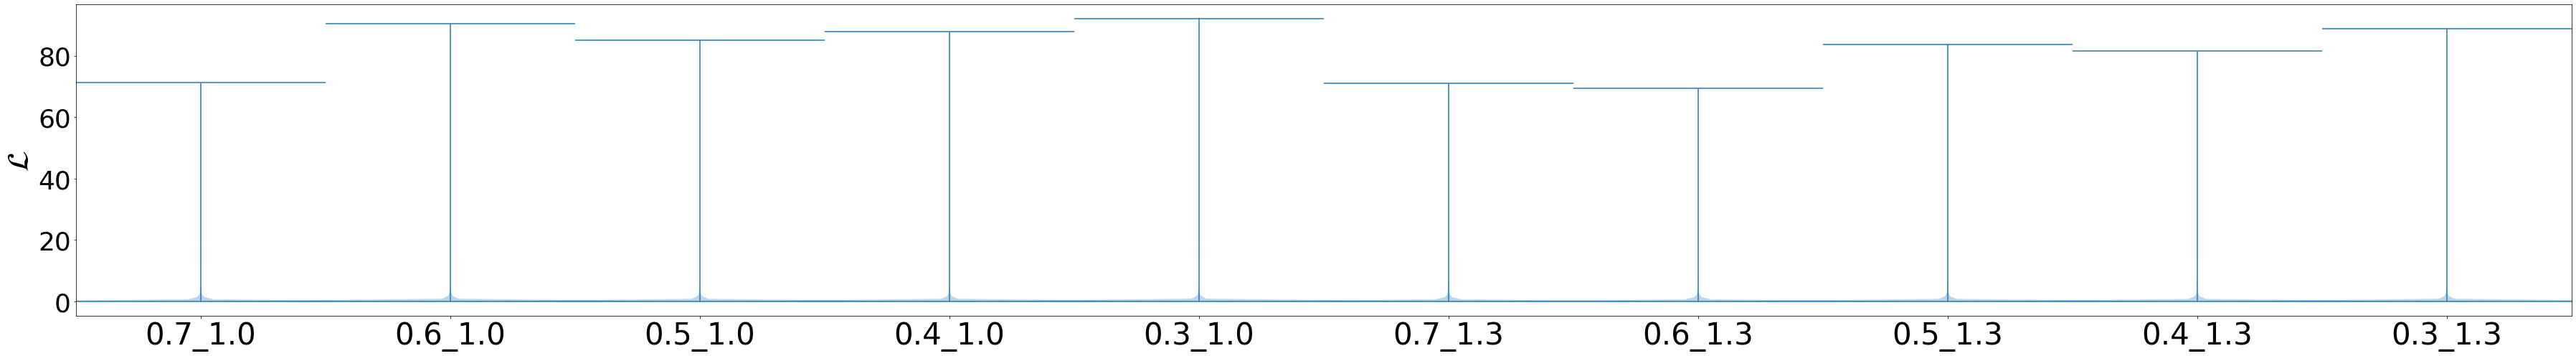

In [237]:
survey = 'COGAL'
survey_file = 'co1_test_regridded'
transition = 'CO 1'
save_str = 'CO1_r400-fhi-fuv'
params = ([0.7, 0.6, 0.5, 0.4, 0.3], np.round(10**np.linspace(0, 2, num=17), decimals=1),)
n_row = 10
violinwidths = 2
violinspace = 1
ymin = 0.8
ymax = 30.01
dy = 1
fontsize = 42
labelsize = 36
rotation = 0

base_dir = f'/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/fit_results/{survey}/{survey_file}/{transition}/'
param_grid = np.meshgrid(*params)
param_grid = np.array([_.flatten() for _ in param_grid]).T
files = []
#param_strs = []
labels = []
for param in param_grid:
    param_str = '-'.join((str(_) for _ in param))
    labels.append(param_str.replace('-', '_'))
    files.append(f'{save_str.split("_")[1]}_{"400-" + param_str}_likelihood.npz')
#files = os.listdir(base_dir)

#L = []
#labels = []

for n in np.arange(0, len(files), n_row):

    L = []
    i_labels = []

    for i, file in enumerate(files[n:(n+n_row)]):

        #if not 'r400-fhi-fuv' in file or 'r400-fhi-fuv_likelihood' in file:
        #    continue
        print(file)
        data = np.load(base_dir + file)
        idx = data['L'] > 0#ymin
        #print(data['L'].size, data['L'][idx].size)
        L.append(copy(data['L'][idx]))
        i_labels.append(labels[n+i])
        #labels.append(file.split('_')[1])
        #labels.append('_'.join((str(_) for _ in data['params'])))

    fig, ax = plt.subplots(figsize=(5*len(L), 7))
    positions = np.arange(1, len(L)+1)
    ax.violinplot(L, positions=positions, widths=violinwidths, showextrema=True)
    ax.set_ylabel(r'$\mathcal{L}$', fontsize=fontsize)
    ax.set_xlim(positions.min()-0.5, positions.max()+0.5)
    ax.set_xticks(positions)
    ax.tick_params(labelsize=labelsize)
    ax.set_xticklabels(i_labels, fontsize=fontsize, rotation=rotation)
    #ax.set_ylim(ymin, ymax)
    #ax.set_yticks(np.arange(ymin, ymax, dy))
    fig.tight_layout()
    plt.savefig(f'plots/{survey}_{save_str}_{n}.png')
    break

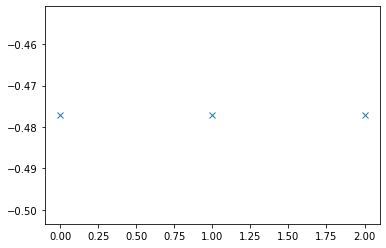

In [22]:
%matplotlib inline
data = np.load('/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/fit_results/Mopra/13co1_test_regridded/13CO 1/r{}_convergence.npy')
plt.plot(data, marker='x', ls='')
plt.show()